# Classification ML Algorithm

It's under **Supervised Learning**. Sample belongs to two or more classes. It's discrete form of ML.

## Get the MNIST data

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
sns.set()

In [3]:
# data is the feature; target it what I want to predict
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
len(mnist['data'])

70000

## 1. Visualization

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

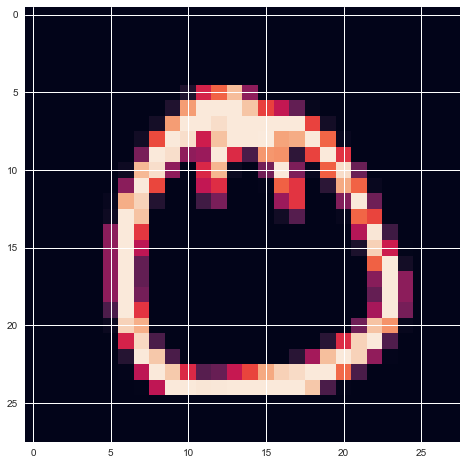

In [8]:
_ = X[1000]
_image = _.reshape(28, 28) #a square matrix, 28 by 28 (28*28 = 784)
plt.imshow(_image)

In [9]:
y[1000]

0.0

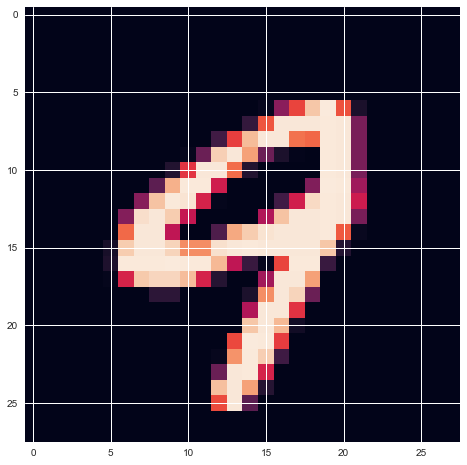

In [10]:
_ = X[69999]
_image = _.reshape(28, 28) #a square matrix, 28 by 28 (28*28 = 784)
plt.imshow(_image)

In [11]:
y[69999]

9.0

In [12]:
# The problem:
# I am given images, converting them to pixels
# I am trying to use these features to train a ML model to identify any future picture given, what variable it is

## 2. Splitting the train and test sets

In [13]:
num_split = 60000

X_train, X_test, y_train, y_test = X[:num_split], X[num_split:], y[:num_split], y[num_split:]

### 2.1 Shuffling the dataset

In [14]:
shuffle_index = np.random.permutation(num_split)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### 2.2 Training a binary classifier
to simplify: Zero or non-zero problem

In [15]:
y_train0 = (y_train ==0)

In [16]:
y_train0

array([False, False, False, ...,  True, False, False], dtype=bool)

In [17]:
y_test0 = (y_test == 0)

In [18]:
y_test0

array([ True,  True,  True, ..., False, False, False], dtype=bool)

Now I have to pick a classifier to train the model. 

Have to choose and test classifiers and tune hyperparameters.

### 2.2.1 SGDClassifier
Stochastic descent classifier

#### Training SGDClassifier

In [19]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(random_state = 0)
clf.fit(X_train, y_train0)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False)

#### Prediction SGDClassifier

As seem above, X[1000] is a zero

In [20]:
clf.predict(X[1000].reshape(1, -1))

array([ True], dtype=bool)

The prediction is False, the model was not able to get it right.
Obviously this is only one data point, which is not enough to evaluate a model

#### Performance measures

* Measure accuracy using cross-validation

* StratifiedKFold

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
clf = SGDClassifier(random_state=0)

In [22]:
skfolds = StratifiedKFold(n_splits=3, random_state=100)

In [23]:
for train_index, test_index in skfolds.split(X_train, y_train0):
    print ("train length: {0}, test lenght: {1} ".format(len(train_index), len(test_index)))
    
    # clone:  Constructs a new estimator with the same parameters.
    clone_clf = clone(clf)
    
    X_train_fold = X_train[train_index]
    y_train_fold = (y_train0[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train0[test_index])
    
    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print("{0:.4f}".format(n_correct / len(y_pred)))

train length: 39999, test lenght: 20001 
0.9860
train length: 40000, test lenght: 20000 
0.9839
train length: 40001, test lenght: 19999 
0.9885


In [24]:
# cross_val_score using K-fold Cross-Validation

In [25]:
from sklearn.model_selection import cross_val_score

In [26]:
cross_val_score(clf, X_train, y_train0, cv=3, scoring='accuracy')

array([ 0.9859507 ,  0.9839    ,  0.98854943])

The model seems to have performed well

## 3. Danger of Blindly Applying Evaluator As a Performance Measure

In [27]:
nZeros = len(y_train0)

In [28]:
# prportion of zeros:
sum(y_train0) / nZeros

0.098716666666666661

In [29]:
# proportion of non-zeros
# dummy classifer
1 - sum(y_train0) / nZeros

0.90128333333333333

Around 90% are not zero

So, if the model predicted that everything was not a zero, that means that the model would be correct around 90% of the time.

The dataset is skewed (as explained above). For **skewed datasets** accuracy **is not the preferred performance measure for classifiers**. Also, that is why data exploration is important.


### Confusion Matrix

In [30]:
from sklearn.model_selection import cross_val_predict

In [31]:
y_train_pred = cross_val_predict(clf, X_train, y_train0, cv=3)

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
confusion_matrix(y_train0, y_train_pred)

array([[53469,   608],
       [  224,  5699]])

#### Precision:
Measures accuracy of positive prediction (2nd column of the confusion matrix).
It tells me how **accurate** my classifier is.

true positive / (false positive + true positive)

In [34]:
from sklearn.metrics import precision_score, recall_score

In [35]:
precision_score(y_train0, y_train_pred) 

0.90359917551926427

In [36]:
#(5558) / (366 + 5558)

#### Recall:
True positive rate; rate of positive correclty detected by the classifier (2nd row)


true positive / (true positive + false negative)

In [37]:
recall_score(y_train0, y_train_pred) 

0.96218132703022119

### F1 Score

Harmonic mean of precision and recall. It favours classifiers that have similar precision and recall and punish the ones which does not.

In [38]:
from sklearn.metrics import f1_score

In [39]:
f1_score(y_train0, y_train_pred)

0.93197056418642676

The value is better than the one got for he dummy classifier!

## Precision / Recall Tradeoff

Increasing precision reduced recall and vice versa

Prediction measures the accuray of positive predictions; Recall measures the rate positive instaces detected by the classifier.

In [40]:
clf = SGDClassifier(random_state=0)
clf.fit(X_train, y_train0)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False)

In [41]:
y[1000]

0.0

In [42]:
y_scores = clf.decision_function(X[1000].reshape(1, -1))
y_scores

array([ 77208.08561988])

In [43]:
threshold = 0

In [44]:
y_some_digits_pred = (y_scores > threshold) # if y_scores is greater than the threshold is True

In [45]:
y_some_digits_pred

array([ True], dtype=bool)

In [46]:
threshold = 40000
y_some_digits_pred = (y_scores > threshold)
y_some_digits_pred

array([ True], dtype=bool)

In [47]:
y_scores = cross_val_predict(clf, X_train, y_train0, cv=3, method='decision_function')

(array([  1.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          3.00000000e+00,   8.00000000e+00,   1.00000000e+01,
          5.00000000e+00,   9.00000000e+00,   1.30000000e+01,
          1.50000000e+01,   8.00000000e+00,   2.70000000e+01,
          2.40000000e+01,   3.20000000e+01,   3.80000000e+01,
          5.30000000e+01,   6.30000000e+01,   5.60000000e+01,
          9.80000000e+01,   1.02000000e+02,   1.22000000e+02,
          1.44000000e+02,   1.78000000e+02,   2.44000000e+02,
          2.93000000e+02,   3.45000000e+02,   4.22000000e+02,
          4.56000000e+02,   5.28000000e+02,   6.43000000e+02,
          7.38000000e+02,   7.68000000e+02,   9.15000000e+02,
          9.96000000e+02,   1.13600000e+03,   1.27900000e+03,
          1.33200000e+03,   1.51000000e+03,   1.68100000e+03,
          1.66400000e+03,   1.94900000e+03,   2.02200000e+03,
          2.13900000e+03,   2.18800000e+03,   2.33300000e+03,
        

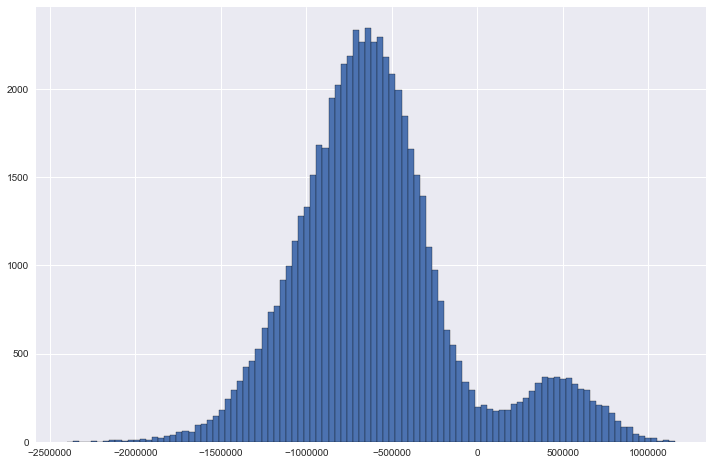

In [48]:
plt.hist(y_scores, bins=100, ec = 'black')

These are the decison scores.

In [49]:
from sklearn.metrics import precision_recall_curve

In [50]:
precisions, recalls, thresholds = precision_recall_curve(y_train0, y_scores)

In [51]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([-0.5,1.5])
    plt.grid()

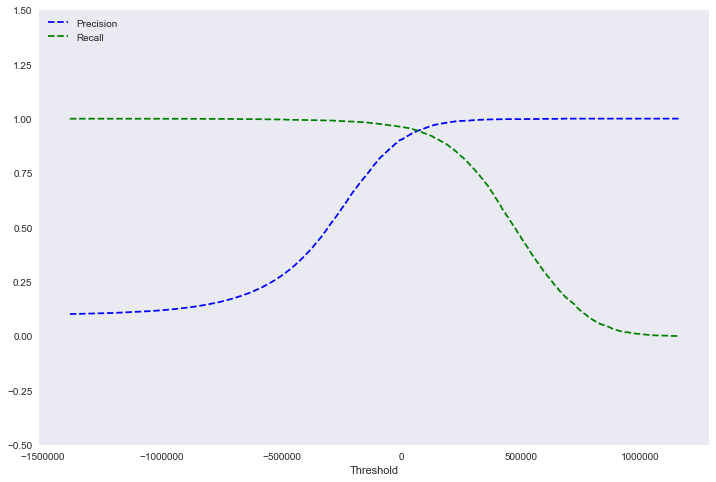

In [52]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Understanding the business problem:

Some taks may require higher precision. For example classifier that picks up adult content for children.

Some tasks may require higher recall. For example detecting intruders on surveillance images (anything that resemble positive instances to be picked up)

In [53]:
# plot precisions against recalls to assist with the threshold selection

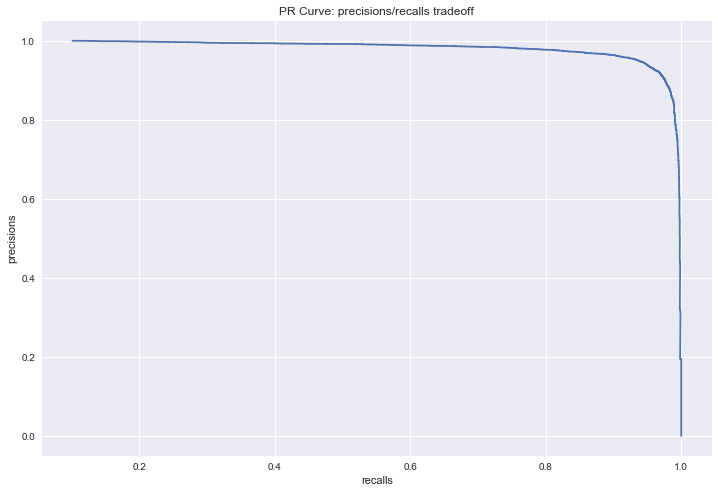

In [54]:
plt.plot(precisions, recalls)
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('PR Curve: precisions/recalls tradeoff')
#plt.grid()

### Setting High Precisions

Aim for 90% precisions.

In [55]:
len(precisions)

58292

In [56]:
len(thresholds)

58291

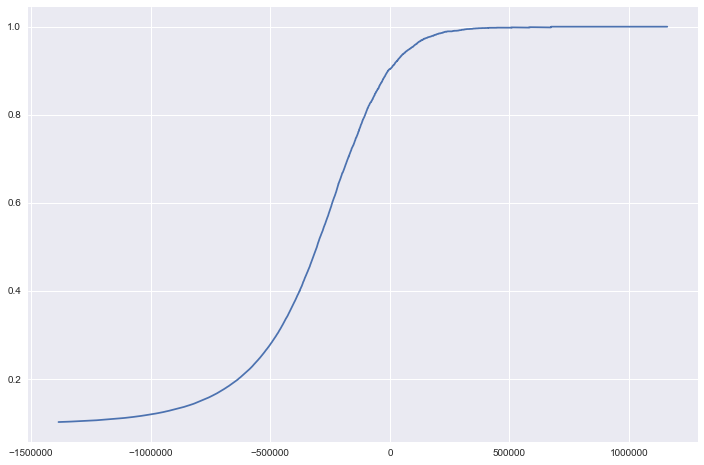

In [57]:
plt.plot(thresholds, precisions[1:])

In [58]:
idx = len(precisions[precisions < 0.9])

In [59]:
thre = thresholds[idx]
thre

-7132.6615321460795

In [60]:
y_train_pred_90 = (y_scores > thre )

In [61]:
precision_score(y_train0, y_train_pred_90)

0.90014197823000475

90% precision score

In [62]:
recall_score(y_train0, y_train_pred_90)

0.96336316056052673

### Setting High Precisions

Aim for 99% precisions.

In [63]:
idx = len(precisions[precisions < 0.99])

In [64]:
thre = thresholds[idx]
thre

261911.81797964851

In [65]:
y_train_pred_99 = (y_scores > thre )

In [66]:
precision_score(y_train0, y_train_pred_99)

0.99017400204708295

In [67]:
recall_score(y_train0, y_train_pred_99)

0.81664696944116155

Recall score went down as I increased precision

### The Receiver Operating Charcteristics (ROC) curve

ROC curve plots the true positive rate (recall) against the false positive rate

In [68]:
from sklearn.metrics import roc_curve

In [69]:
fpr, tpr, thresholds = roc_curve(y_train0, y_scores)

In [70]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

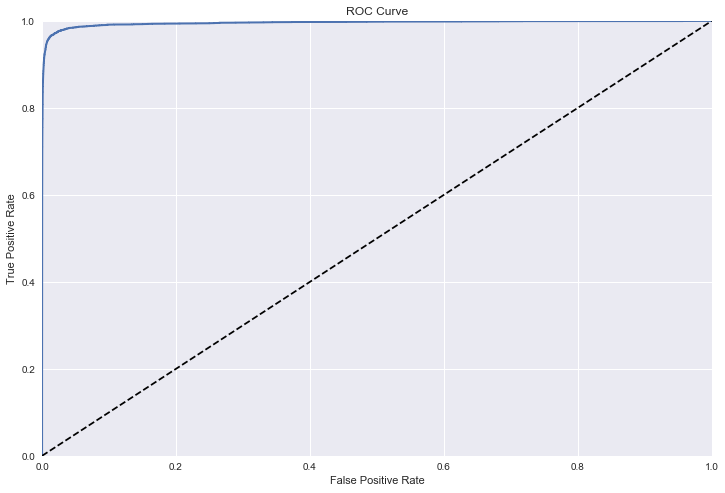

In [71]:
plot_roc_curve(fpr, tpr)

In [72]:
from sklearn.metrics import roc_auc_score

In [74]:
roc_auc_score(y_train0, y_scores)

0.99547078758398155

Use **PR curve** whenever the positive class is rare or when you care more about the false positives than the false negatives.

Use **ROC curve** whenever the negative class is rare or when you care more about the false negatives than the false positives

In the example above, the ROC curve seemed to suggest that the classifier is good. However, when you look at the PR curve, you can see that there are room for improvement.

## 4. Model Comparison

### 4.1 Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
f_clf = RandomForestClassifier(random_state=0)

In [81]:
y_probas_forest = cross_val_predict(f_clf, X_train, y_train0,
                                   cv=3, method='predict_proba')

In [82]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train0, y_scores_forest)

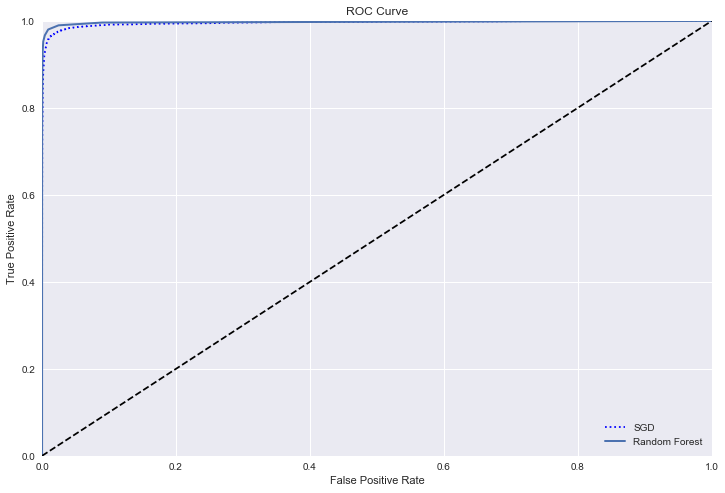

In [83]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

Performance of Random Forest is better

In [85]:
roc_auc_score(y_train0, y_scores_forest)

0.99722240912278237

AUC score is higher for random forest

In [86]:
f_clf.fit(X_train, y_train0)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [87]:
y_train_rf = cross_val_predict(f_clf, X_train, y_train0, cv=3)

In [88]:
precision_score(y_train0, y_train_rf)

0.99083722601509161

In [89]:
recall_score(y_train0, y_train_rf)

0.93111598851933142

In [90]:
confusion_matrix(y_train0, y_train_rf)

array([[54026,    51],
       [  408,  5515]])

Random Forest is much better

***